In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
from pprint import pprint
import xml.etree.ElementTree as ET
import json
from pathlib import Path
import struct

In [8]:
!pip install xmltodict

You should consider upgrading via the '/home/tigran-analysed/Desktop/analysed.ai/table_extractor/venv/bin/python3.10 -m pip install --upgrade pip' command.


In [9]:
import xmltodict

In [10]:
DATASETS_PATH = "../datasets/Marmot_data/orig_data/"
ORIG_DS_PATH = "../datasets/marmot_dataset_v1.0/data_copy/"
DATASET_IMAGES_PATH = DATASETS_PATH + "Images/"
DATASET_MASKS_PATH = DATASETS_PATH + "Masks/"

In [11]:
def imshow(image, fac=50):
    fig = plt.figure(figsize=(image.shape[0]/fac, image.shape[1]/fac))
    ax = fig.add_subplot()
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

In [17]:
with open(DATASETS_PATH + "10.1.1.193.1818_3.xml", "r") as f:
    ann_dict = xmltodict.parse("\n".join(f.readlines()))

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/Marmot_data/orig_data/10.1.1.193.1818_3.xml'

In [8]:
pprint(ann_dict)

{'annotation': {'filename': '10.1.1.193.1818_3.bmp',
                'folder': 'MARMOT_ANNOTATION',
                'object': [{'bndbox': {'xmax': '446',
                                       'xmin': '411',
                                       'ymax': '388',
                                       'ymin': '215'},
                            'difficult': '0',
                            'name': 'column',
                            'pose': 'Unspecified',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '494',
                                       'xmin': '469',
                                       'ymax': '382',
                                       'ymin': '219'},
                            'difficult': '0',
                            'name': 'column',
                            'pose': 'Unspecified',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '545',
                                

In [9]:
def get_table_bbox(table_xml_path, new_image_shape):
    
    """
    - Extract Table Coordinates from xml
    - Scale them w.r.t to new image shape
    
    Input:
        table_xml_path: str - xml path
        new_image_shape: tuple - (new_h, new_w)
    
    Output:
        table_bboxes: List 
    """

    tree = ET.parse(table_xml_path)
    root = tree.getroot()

    px0, py1, px1, py0 = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], root.get("CropBox").split()))
    pw = abs(px1 - px0)
    ph = abs(py1 - py0)

    table_bboxes = []

    for table in root.findall(".//Composite[@Label='TableBody']"):
        x0p, y0m, x1p,y1m  = list(map(lambda x: struct.unpack('!d', bytes.fromhex(x))[0], table.get("BBox").split()))
        x0 = round(new_image_shape[1]*(x0p - px0)/pw)
        x1 = round(new_image_shape[1]*(x1p - px0)/pw)
        y0 = round(new_image_shape[0]*(py1 - y0m)/ph)
        y1 = round(new_image_shape[0]*(py1 - y1m)/ph)
        
        table_bboxes.append([x0,y0, x1,y1])
    return table_bboxes

In [10]:
DS_ENGLISH_PATH = ORIG_DS_PATH + "English/"

In [11]:
get_table_bbox(ORIG_DS_PATH + "positive/" + '1_33.xml', (500, 500))

[[11, 211, 486, 263]]

In [12]:
def anshow(name, fac=50):
    img = cv2.imread(ORIG_DS_PATH + "positive/" + name)
    base_name = ".".join(name.split(".")[:-1])
    bboxes = get_table_bbox(ORIG_DS_PATH + "positive/" + base_name + ".xml", (img.shape[0], img.shape[1]))

    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        img = cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
        
    imshow(img, fac)

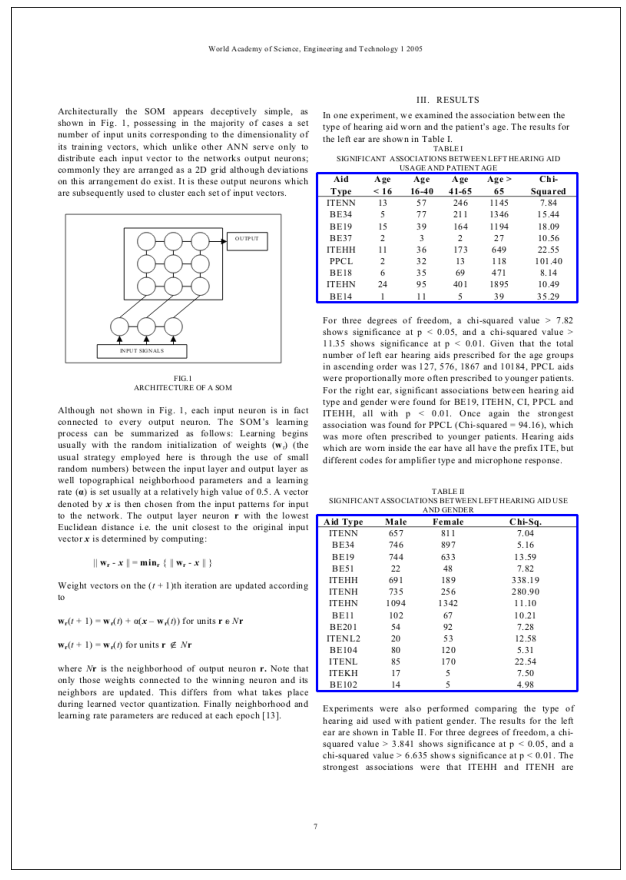

In [13]:
anshow("10.1.1.193.1818_3.bmp")

In [14]:
def save_annotation(name, fac=50):
    img = cv2.imread(ORIG_DS_PATH + "positive/" + name)
    base_name = ".".join(name.split(".")[:-1])
    bboxes = get_table_bbox(ORIG_DS_PATH + "positive/" + base_name + ".xml", (img.shape[0], img.shape[1]))
    mask = np.zeros((img.shape[0], img.shape[1]))
    for bbox in bboxes:
        x1, y1, x2, y2 = bbox
        mask = cv2.rectangle(mask, (x1, y1), (x2, y2), color=(255, 255, 255), thickness=-1)
    
    cv2.imwrite(ORIG_DS_PATH + "Images/" + name, img)
    cv2.imwrite(ORIG_DS_PATH + "Masks/" + base_name + "_mask.bmp", mask)

In [15]:
from pathlib import Path

In [103]:
for p in Path(ORIG_DS_PATH + "positive").glob("*.bmp"):
    print(f"Saving {p}.", end="\r")
    save_annotation(str(p.name))

In [16]:
for p in Path(ORIG_DS_PATH + "negative").glob("*.bmp"):
    print(f"Saving {p}.", end="\r")
    cv2.imwrite(ORIG_DS_PATH + "Negative_Images/" + p.name, cv2.imread(str(p)))